In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.chdir('/content/drive/My Drive/Tesi')

In [ ]:
import cv2
import math
import copy
import random
import numpy as np
import pandas as pd
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import load_model
from tensorflow.keras.utils import Sequence

import warnings
warnings.filterwarnings('ignore')

In [ ]:
sequence_length = 4
sequence_stride = 2
batch_size      = 16

# Network model

## Loading the pre-trained model

In [ ]:
ed_path = 'models/wild/ED_wild_pre-trained.h5'
ed = load_model(ed_path)

ed.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

## Remove the top layers

In [ ]:
from keras import Model

ed_nofreeze = Model(inputs=ed.input, outputs=ed.layers[-4].output)

for layer in ed_nofreeze.layers:
  layer.trainable = True

ed_nofreeze.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']    

## CNN + LSTM

In [ ]:
from keras.layers import TimeDistributed, Input, LSTM, Dense, Dropout

input_layer = Input(shape=(sequence_length, 224, 224, 3))
ed_reshaped = TimeDistributed(ed_nofreeze)(input_layer)
CNNandLSTM = LSTM(100, activation='relu')(ed_reshaped)
dropout = Dropout(0.5)(CNNandLSTM)
output = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=input_layer, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 224, 224, 3)]  0         
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 1280)          4049571   
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 100)               552400    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 4,602,072
Trainable params: 4,560,049
Non-trainable params: 42,023
____________________________________________

In [ ]:
model.save('models/wild/ED_LSTM_wild_trainable_True.h5')

# Inference with pre-trained CNN on single test frames

In [ ]:
path = 'csv/Test/wild/KFold_short-range/fold3'
csvs = os.listdir(path)
test_data = {'filename':[], 'Flames':[]}

for csv in csvs:
    temp = pd.read_csv(path + '/' + csv)
    for index, row in temp.iterrows():
      test_data['filename'].append(row['filename'])
      test_data['Flames'].append(row['Flames'])

test_data = pd.DataFrame(test_data)
print("Test data samples: " + str(len(test_data)) + ".\nPositive test frames: " +
      str(test_data[test_data['Flames'] == 1].count()[0]) + ".\nNegative test frames: " +
      str(test_data[test_data['Flames'] == 0].count()[0]) + ".")

In [ ]:
# putting our test data labels in the proper format and shape desired
col = test_data['Flames']
col = list(col)

t = []
for i in col:
  t.append(str(i))

td = {'filename':[], 'Flames':[]}

for index, row in test_data.iterrows():
  td['filename'].append(row['filename'])
  td['Flames'].append(t[index])

test_data = pd.DataFrame(td)

In [ ]:
new_test_data = {'filename':[], 'Flames':[]}

for index, row in test_data.iterrows():
  new_test_data['filename'].append('/content/drive/My Drive' + row['filename'][30:])
  new_test_data['Flames'].append(str(row['Flames']))

n_t_d = pd.DataFrame(new_test_data)

In [ ]:
import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger, EarlyStopping

test_datagen = ImageDataGenerator(preprocessing_function = tensorflow.keras.applications.mobilenet_v2.preprocess_input)

test_generator = test_datagen.flow_from_dataframe(dataframe = n_t_d, 
                                                    x_col='filename', 
                                                    y_col='Flames', 
                                                    class_mode='binary',
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    shuffle=False)

In [ ]:
from keras.models import load_model

ed_path = 'models/wild/ED_wild_pre-trained.h5'
ed = load_model(ed_path)

pred = ed.predict(test_generator)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(y, pred):
  p = pred.argmax(-1)
  cm = confusion_matrix(y, p)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title('Accuracy: %.3f' % (y==p).mean())
  plt.show()

In [ ]:
test_lab = []
for i in list(n_t_d['Flames']):
  test_lab.append(int(i))
plot_cm(y=test_lab, pred=pred)

# Evaluate

In [ ]:
# tensorflow version must be the 2.6.2 and keras version must be 2.6.0.
!pip install tensorflow==2.6.2
%tensorflow_version 2.6.2

# !!!!!!!!!!!!!! AFTER EXECUTING THIS CELL, RESTART THE RUNTIME !!!!!!!!!!!!!!!!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.4/458.4 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.9/462.9 KB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 82.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 25.2 MB/s eta 0:00:00
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=1f439ccd95f4c8a383d477076659010700cb66bb5753625562382

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.6.2


In [ ]:
from tensorflow import keras
print(keras.__version__)

2.6.0


46/46 [==============================] - 721s 16s/step


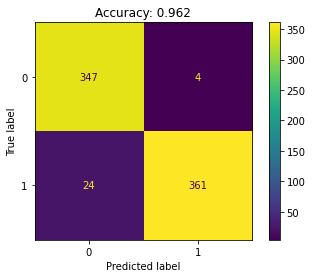

In [ ]:
import os
import cv2
import math
import copy
import random
import numpy as np
import pandas as pd
import albumentations as A
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import load_model
from tensorflow.keras.utils import Sequence
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import SGD
import warnings
warnings.filterwarnings('ignore')



sequence_length = 4
sequence_stride = 2
batch_size      = 16

def file_generator(data_path, data_files, temporal_stride, temporal_length):
  '''
  data_files - list of csv files to be read
  '''
  for f in data_files:
    tmp_df = pd.read_csv(os.path.join(data_path, f))
    total_images = len(tmp_df)
    if total_images >= temporal_length:
      num_samples = int((total_images - temporal_length)/temporal_stride) + 1
      # print('num of samples from vid seq-{}: {}'.format(f, num_samples))
    else:
      # print('num of frames is less than temporal length; hence discarding this \
      #       file-{}'.format(f))
      continue

    samples = deque()
    labels = deque()

    for index, row in tmp_df.iterrows():
      samples.append('/content/drive/My Drive' + row['filename'][30:])
      labels.append(int(row['Flames']))
      if len(samples) == temporal_length:
        to_delete = False
        if labels.count(labels[0]) != len(labels):
          to_delete = True
        samples_c = copy.deepcopy(samples)
        for t in range(temporal_stride):
          samples.popleft()
          labels.popleft()
        if to_delete: continue
        yield samples_c, labels[0]

def load_samples(CSV_folder, temporal_stride, temporal_length):
  data_path = os.path.join('csv', CSV_folder)
  data_files = os.listdir(data_path)
  file_gen = file_generator(data_path, data_files, temporal_stride, temporal_length)
  iterator = True
  data_list = []

  while iterator:
    try:
      x, y = next(file_gen)
      x = list(x)
      data_list.append([x, y])
    except Exception as e:
      # print('Exception: ', e)
      iterator = False
      # print('end of data generator ')
  return data_list

class DataGenerator(Sequence):

    def __init__(self, data, batch_size, shuffle_data, aug):
        self.num_samples = len(data)
        self.data = shuffle(data) if shuffle_data else data
        self.batch_size = batch_size
        self.aug = aug        
        self.additional_targets = {[f'image{i}' for i in range(sequence_length-1)][j]:'image' for j in range(sequence_length-1)}

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, idx):
        #print('starting index: ', idx * self.batch_size)
        batch_samples = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_train = []
        y_train = []
        for batch_sample in batch_samples:
            x = batch_sample[0]   # Load image (X)
            y = batch_sample[1]   # Read label (y)
            temp_data_list = []
            for img_name in x:
                try:
                    img = cv2.imread(img_name)
                    img = cv2.resize(img, (224,224))
                    temp_data_list.append(img[:,:, ::-1])
                except Exception as e:
                    print(e)
                    print('error reading file: ', img_name)
            if self.aug:
                temp_data_list = self.__totransform__(temp_data_list)
            # Add example to arrays
            X_train.append(temp_data_list)
            y_train.append(y)
        # Make sure they're numpy arrays (as opposed to lists)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        return X_train, y_train

test_data = load_samples(CSV_folder='Test/wild/KFold_short-range/fold3', temporal_stride=sequence_stride,
                            temporal_length=sequence_length)

test_gen = DataGenerator(data=test_data, batch_size=batch_size, 
                         shuffle_data=False, aug=False)

model = load_model('models/wild/short-range/EfficientDet/case4/case4_best_model3.h5')

groundtruth = []
for sample in test_data:
  groundtruth.append(sample[1])

pred = model.predict(test_gen)
predictions = []
for i in range(len(pred)):
  if pred[i][0] > 0.5:
    predictions.append(1)
  else:
    predictions.append(0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(data, pred):
  y = np.array(data)
  p = np.array(pred)
  cm = confusion_matrix(y, p)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title('Accuracy: %.3f' % (y==p).mean())
  plt.show()
plot_cm(data=groundtruth, pred=predictions)

In [ ]:
model.evaluate(test_gen)

46/46 [==============================] - 286s 6s/step - loss: 0.0780 - accuracy: 0.9620


[0.07804408669471741, 0.9619565010070801]

In [ ]:
p = []
for i in pred:
  p.append(round(list(i)[0]))
p = np.array(p)
y = np.array(groundtruth)

groundtruth = list(y)
scores = list(p)

In [ ]:
from keras.metrics import AUC # Approximates the Area Under the Curve of the ROC curve
from sklearn.metrics import balanced_accuracy_score

b_acc = balanced_accuracy_score(y_true=y, y_pred=p)

TP=TN=FP=FN = 0

for i in range(len(groundtruth)):
    if groundtruth[i] == 1 and scores[i] == 1:
        TP = TP + 1
    elif groundtruth[i] == 0 and scores[i] == 0:
        TN = TN + 1
    elif groundtruth[i] == 0 and scores[i] == 1:
        FP = FP + 1
    elif groundtruth[i] == 1 and scores[i] == 0:
        FN = FN + 1

AR = (TP + TN)/(TP + TN + FP + FN)
Precision = TP/(TP + FP)
Recall = TP/(TP + FN)
TPR = TP/(TP + FN)
TNR = TN/(TN + FP)
FPR = FP/(FP + TN)
FNR = FN/(FN + TP)
F1score = (2 * Precision * Recall)/(Precision + Recall)
Auc = AUC()
Auc.update_state(groundtruth, scores)

print("True Positives: " + str(TP) + "\nTrue Negatives: " + str(TN) + 
      "\nFalse Positives: " + str(FP) + "\nFalse Negatives: " + str(FN) +
      "\nTrue Positive rate: " + str(round(TPR, 3)) + "\nTrue negative rate: " +
      str(round(TNR, 3)) + "\nFalse Positive rate: " + str(round(FPR, 3)) +
      "\nFalse Negative rate: " + str(round(FNR, 3)) + "\nAccuracy Rate: " + 
      str(round(AR, 3)) + "\nPrecision: " + str(round(Precision, 3)) + 
      "\nRecall: " + str(round(Recall, 3)) + "\nBalanced accuracy: " + 
      str(round(b_acc, 3)) + "\nF1-Score: " + str(round(F1score, 3)) + 
      "\nArea under ROC curve: " + str(round(float(Auc.result()), 3)))

True Positives: 361
True Negatives: 347
False Positives: 4
False Negatives: 24
True Positive rate: 0.938
True negative rate: 0.989
False Positive rate: 0.011
False Negative rate: 0.062
Accuracy Rate: 0.962
Precision: 0.989
Recall: 0.938
Balanced accuracy: 0.963
F1-Score: 0.963
Area under ROC curve: 0.963


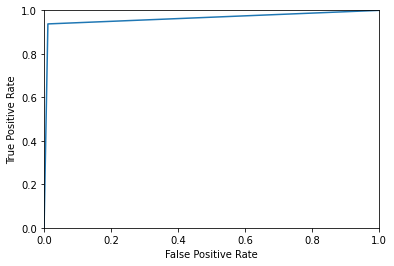

In [ ]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()

p = []
for i in pred:
  p.append(round(list(i)[0]))
p = np.array(p)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true=np.array(groundtruth), y_score=p)
plot_roc_curve(fpr_keras,tpr_keras)

## Which samples are wrongly predicted?

In [ ]:
wrong_predictions01 = []

for i in range(len(groundtruth)):
    if test_data[i][1] == 0 and scores[i] == 1:
      wrong_predictions01.append(test_data[i][0])
for i in range(len(wrong_predictions01)):
  print(wrong_predictions01[i])

['/content/drive/My Drive/Tesi/datasets/wild/short-range/Storyblocks/frames/negative/river-in-mysterious-forest-with-fog-SBV-346824880-preview.mp4/11.jpg', '/content/drive/My Drive/Tesi/datasets/wild/short-range/Storyblocks/frames/negative/river-in-mysterious-forest-with-fog-SBV-346824880-preview.mp4/12.jpg', '/content/drive/My Drive/Tesi/datasets/wild/short-range/Storyblocks/frames/negative/river-in-mysterious-forest-with-fog-SBV-346824880-preview.mp4/13.jpg', '/content/drive/My Drive/Tesi/datasets/wild/short-range/Storyblocks/frames/negative/river-in-mysterious-forest-with-fog-SBV-346824880-preview.mp4/14.jpg']
['/content/drive/My Drive/Tesi/datasets/wild/short-range/Storyblocks/frames/negative/river-in-mysterious-forest-with-fog-SBV-346824880-preview.mp4/13.jpg', '/content/drive/My Drive/Tesi/datasets/wild/short-range/Storyblocks/frames/negative/river-in-mysterious-forest-with-fog-SBV-346824880-preview.mp4/14.jpg', '/content/drive/My Drive/Tesi/datasets/wild/short-range/Storyblocks/

In [ ]:
wrong_predictions10 = []

for i in range(len(groundtruth)):
    if test_data[i][1] == 1 and scores[i] == 0:
      
      wrong_predictions10.append(test_data[i][0])
for i in range(len(wrong_predictions10)):
  print(wrong_predictions10[i])

['/content/drive/My Drive/Tesi/datasets/wild/short-range/Depositphotos/frames/positive/depositphotos_534821736-stock-video-field-carpathian-mountains-village-bright.mp4/1.jpg', '/content/drive/My Drive/Tesi/datasets/wild/short-range/Depositphotos/frames/positive/depositphotos_534821736-stock-video-field-carpathian-mountains-village-bright.mp4/2.jpg', '/content/drive/My Drive/Tesi/datasets/wild/short-range/Depositphotos/frames/positive/depositphotos_534821736-stock-video-field-carpathian-mountains-village-bright.mp4/3.jpg', '/content/drive/My Drive/Tesi/datasets/wild/short-range/Depositphotos/frames/positive/depositphotos_534821736-stock-video-field-carpathian-mountains-village-bright.mp4/4.jpg']
['/content/drive/My Drive/Tesi/datasets/wild/short-range/Depositphotos/frames/positive/depositphotos_534821736-stock-video-field-carpathian-mountains-village-bright.mp4/3.jpg', '/content/drive/My Drive/Tesi/datasets/wild/short-range/Depositphotos/frames/positive/depositphotos_534821736-stock-vi

In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = test_data[0][0][0]
uno = video_name[55:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[55:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in test_data:
  video_name = list_of_lists[0][0]
  uno = video_name[55:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[55:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df = pd.DataFrame(all_videos)
df

,name,num
0,forest3.avi,10
1,depositphotos_241227250-stock-video-close-camp...,31
2,depositphotos_367618068-stock-video-forest-fir...,5
3,depositphotos_402052830-stock-video-forest-fir...,20
4,depositphotos_409156282-stock-video-night-vide...,29
5,depositphotos_455107056-stock-video-forest-fir...,24
6,depositphotos_462622938-stock-video-burning-fi...,13
7,depositphotos_466384010-stock-video-timanfaya-...,11
8,depositphotos_475663600-stock-video-forest-fir...,14
9,depositphotos_534821736-stock-video-field-carp...,24


In [ ]:
for index,row in df.iterrows():
  print(row['name'])

forest3.avi
depositphotos_241227250-stock-video-close-campfire-mountain-river-rocky.mp4
depositphotos_367618068-stock-video-forest-fire-fire-destroys-trees.mp4
depositphotos_402052830-stock-video-forest-fire-disaster-burning-caused.mp4
depositphotos_409156282-stock-video-night-video-bonfire-tourist-camp.mp4
depositphotos_455107056-stock-video-forest-fire-disaster-burning-caused.mp4
depositphotos_462622938-stock-video-burning-fire-in-slow-motion.mp4
depositphotos_466384010-stock-video-timanfaya-parque-nacional-de-timanfaya.mp4
depositphotos_475663600-stock-video-forest-fire-disaster-burning-caused.mp4
depositphotos_534821736-stock-video-field-carpathian-mountains-village-bright.mp4
depositphotos_550140240-stock-video-wildfire-disaster-burning-tropical-forest.mp4
depositphotos_604889248-stock-video-campfire-mountain-camp-fire-burning.mp4
depositphotos_61412485-stock-video-wildfire-in-mountain-of-thailandpan.mp4
a-beautiful-forest-on-a-sunny-day-SBV-336251067-preview.mp4
arson-fire-danger

In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = wrong_predictions10[0][0]
uno = video_name[55:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[55:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in wrong_predictions10:
  video_name = list_of_lists[0]
  uno = video_name[55:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[55:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df_wrong10 = pd.DataFrame(all_videos)

In [ ]:
df_wrong10

,name,num
0,depositphotos_534821736-stock-video-field-carp...,24


In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = wrong_predictions01[0][0]
uno = video_name[55:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[55:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in wrong_predictions01:
  video_name = list_of_lists[0]
  uno = video_name[55:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[55:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df_wrong01 = pd.DataFrame(all_videos)
df_wrong01

,name,num
0,river-in-mysterious-forest-with-fog-SBV-346824...,2
1,scenic-forest-of-fresh-green-deciduous-trees-f...,1
2,tall-trees-silhouette-in-front-of-the-milky-wa...,1


In [ ]:
for index,row in df_wrong01.iterrows():
  print(row['name'])

fire-fighter-plane-drops-fire-retardant-on-a-forest-fire-in-the-hills-SBV-338590163-preview.mp4
